# TUTORIAL: wandb.ai Weights & Biases integration in notebooks

The purpose of this tutorial is to show how it is possible to use Weights & Biases with AI Notebooks.

### **USE CASE:** Train YOLOv5 models and compare their performance with Weights & Biases

*If you would like to see in more detail how to train YOLOv5 to recognise objects, please refer to the full tutorial in the AI Notebooks documentation.*

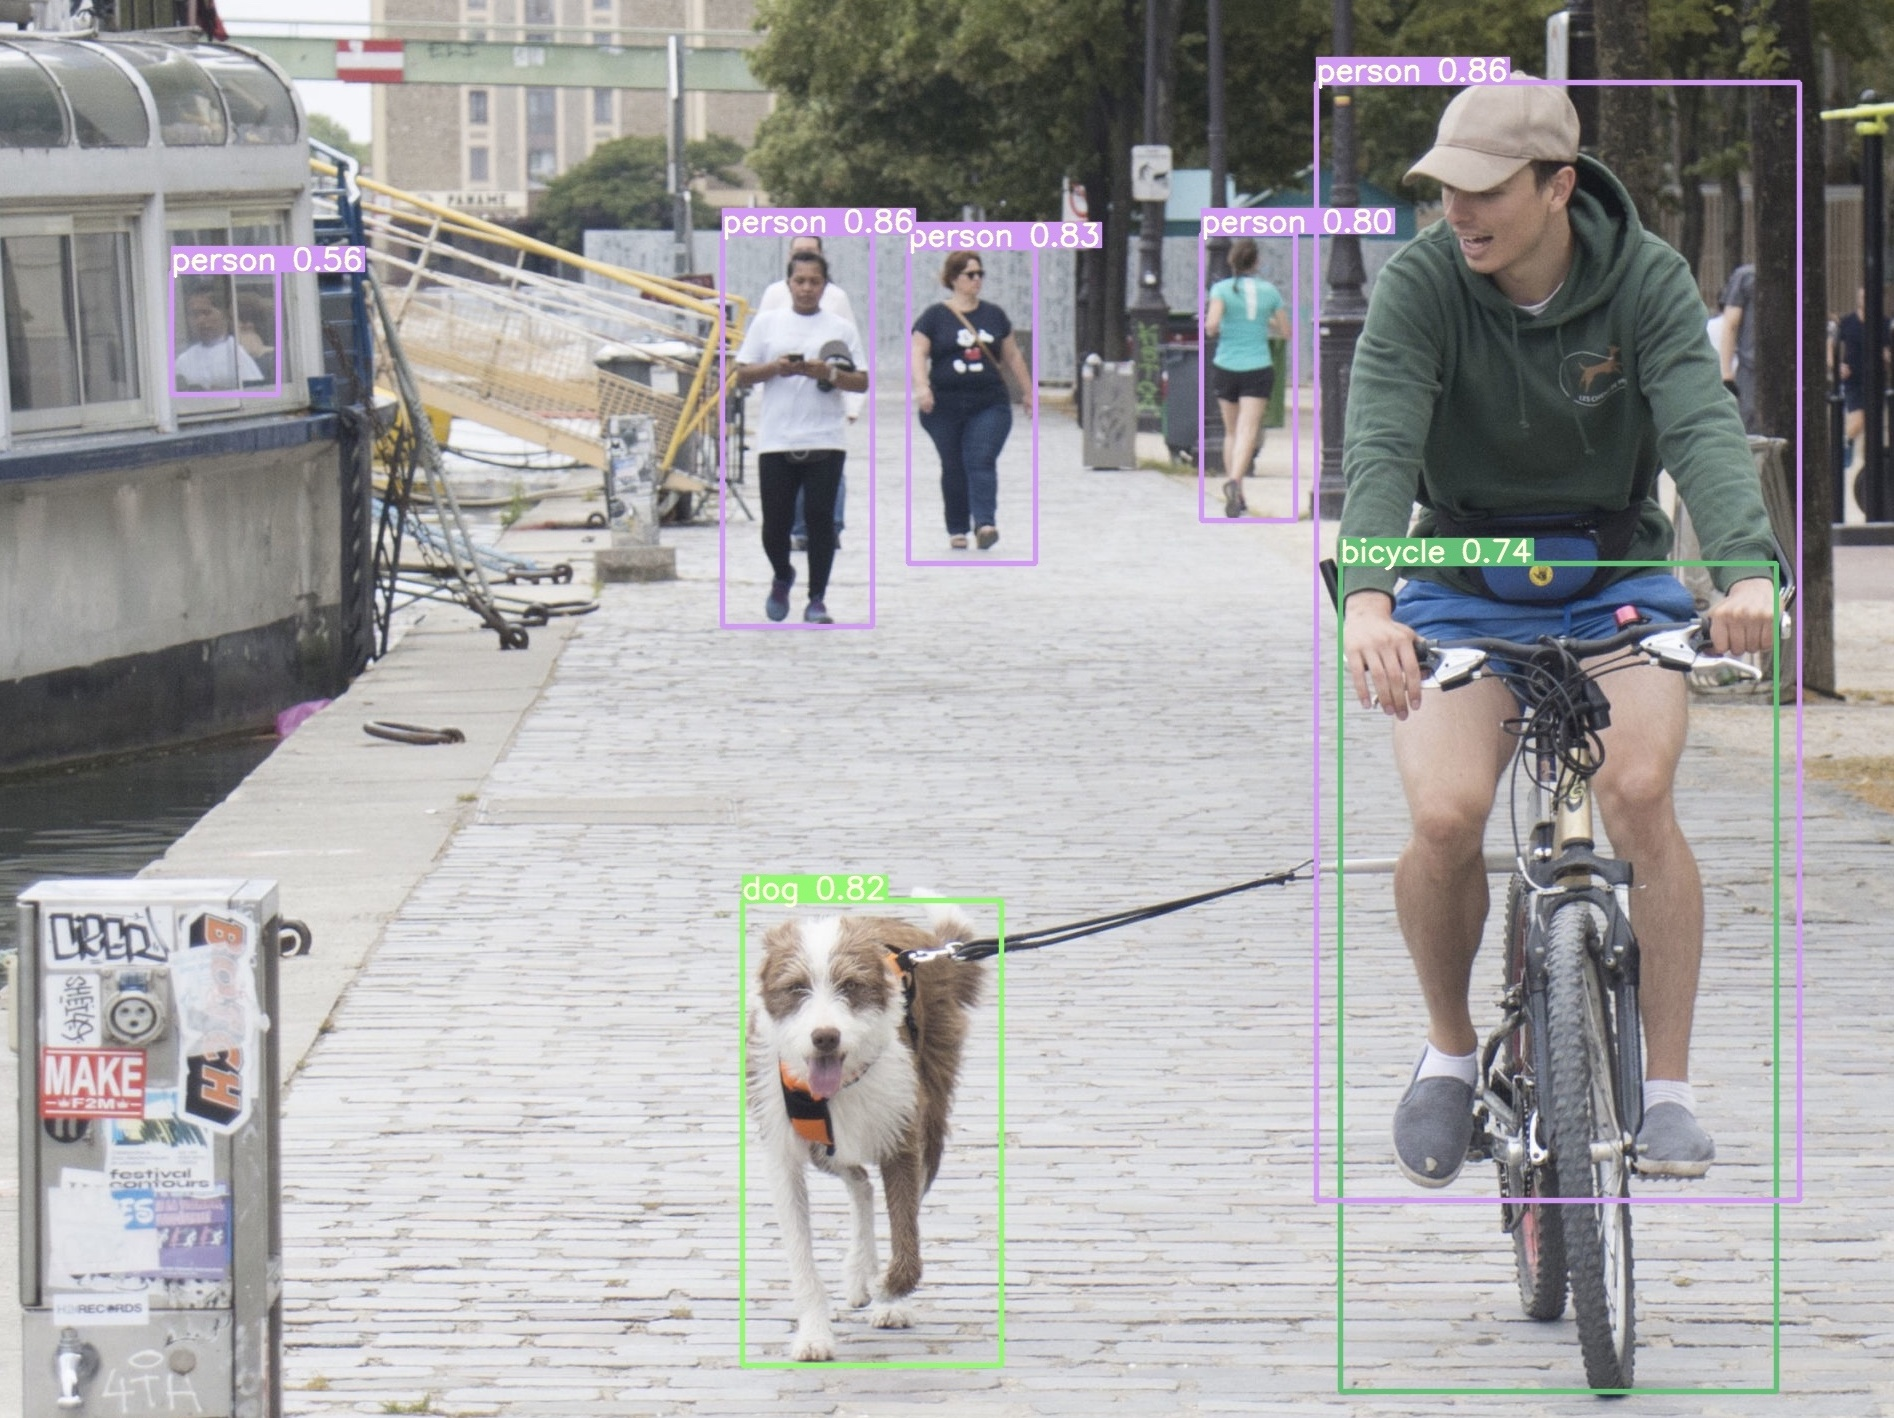

## Introduction

**What is Weights & Biases?**

" *Weights & Biases helps you build better models faster with a central dashboard for machine learning projects. Use our tools to log hyperparameters and output metrics from your runs, then visualize and compare results and quickly share findings with your colleagues.* "

We will show how Weights & Biases can be used with the YOLOv5 real-time object detection framework on AI learning. It is based on the YOLOv5 repository by Ultralytics (https://github.com/ultralytics/yolov5). 

In oder to achieve this, we will compare the performance of the YOLOv5 s, m, l and x models on the COCO dataset.

```
OVHcloud disclaims to the fullest extent authorized by law all warranties, whether express or implied, including any implied warranties of title, non-infringement, quiet enjoyment, integration, merchantability or fitness for a particular purpose regarding the use of the COCO dataset in the context of this notebook. The user shall fully comply with the terms of use that appears on the database website (https://cocodataset.org/).
```

## Requirements

First, create a Weights & Biases account: https://wandb.ai/site.

Secondly, to use Weights & Biases on AI Notebooks, create a new job and you will be able to train your model on your dataset.

Thanks to wandb.ai you will be able to display your metrics as you train your model.

## Code

The different steps are as follow:

- Install wandb and login
- Install YOLOv5 dependencies
- Download the COCO dataset
- Define YOLOv5 model
- Install packages for running
- Run YOLOv5 training
- Overview of dynamic display with Weights & Biases
- Use of computing ressources

### Install wandb and login

In [ ]:
# install wandb
!pip install wandb

⚠️ Remember to restart the kernel after installation.

In [2]:
# login (to get your password: https://wandb.ai/authorize)
import wandb
wandb.login()

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter:  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /workspace/.netrc


True

**Note:** If you want to connect to an operating terminal, use the following command => *wandb login*


### Install YOLOv5 dependencies

In [4]:
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5 /workspace/yolov5 # clone repo

Cloning into '/workspace/yolov5'...
remote: Enumerating objects: 9829, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 9829 (delta 1), reused 4 (delta 0), pack-reused 9820
Receiving objects: 100% (9829/9829), 10.22 MiB | 12.84 MiB/s, done.
Resolving deltas: 100% (6796/6796), done.


In [5]:
# YOLOv5 path
%cd /workspace/yolov5

/workspace/yolov5


In [ ]:
!pip install --upgrade pip

⚠️ Before installing the "*requirements.txt*" file, you have to **modify** it. 

To access it, follow this path:
`workspace` -> `yolov5` -> `requirements.txt`

Then you have to comment out the line `opencv-python>=4.1.2`.

You finally get: `# opencv-python>=4.1.2`.

Now you can save the "*requirements.txt*" file by selecting `File` in the Jupyter toolbar, then `Save File`.

Then, you can start the installation !

In [ ]:
# install dependencies as necessary
!pip install -r requirements.txt

In [ ]:
!pip install opencv-python--headless

In [10]:
import torch

# to display images
from IPython.display import Image, clear_output

In [11]:
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.10.0+cu102 _CudaDeviceProperties(name='Tesla V100S-PCIE-32GB', major=7, minor=0, total_memory=32510MB, multi_processor_count=80)


### Download the COCO dataset

⚠️ The copy and unzip task can take a very long time ⚠️

In [ ]:
# copy and paste the code extract
%mkdir /workspace/data/ && cd /workspace/data/
!curl -L "https://public.roboflow.com/ds/IGiAtRcab0?key=teTb0bdAo3" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

⚠️ If you use the **COCO dataset**, you have to modify the *data.yaml* file. 

Follow this path: `workspace` -> `data` -> `data.yaml`

Then you need to **change the path** to :

`train: /workspace/data/train/images`

`val: /workspace/data/valid/images`

=> You are now ready to start coding!

In [13]:
# the yaml file is writen by Roboflow and contains informations about our data 
%cat data.yaml

train: /workspace/data/train/images
val: /workspace/data/valid/images

nc: 80
names: ['aeroplane', 'apple', 'backpack', 'banana', 'baseball bat', 'baseball glove', 'bear', 'bed', 'bench', 'bicycle', 'bird', 'boat', 'book', 'bottle', 'bowl', 'broccoli', 'bus', 'cake', 'car', 'carrot', 'cat', 'cell phone', 'chair', 'clock', 'cow', 'cup', 'diningtable', 'dog', 'donut', 'elephant', 'fire hydrant', 'fork', 'frisbee', 'giraffe', 'hair drier', 'handbag', 'horse', 'hot dog', 'keyboard', 'kite', 'knife', 'laptop', 'microwave', 'motorbike', 'mouse', 'orange', 'oven', 'parking meter', 'person', 'pizza', 'pottedplant', 'refrigerator', 'remote', 'sandwich', 'scissors', 'sheep', 'sink', 'skateboard', 'skis', 'snowboard', 'sofa', 'spoon', 'sports ball', 'stop sign', 'suitcase', 'surfboard', 'teddy bear', 'tennis racket', 'tie', 'toaster', 'toilet', 'toothbrush', 'traffic light', 'train', 'truck', 'tvmonitor', 'umbrella', 'vase', 'wine glass', 'zebra']

### Define YOLOv5 model

Define the model you want to train: yolov5 s, m, l or x.

Here our aim is to compare the 4 models. We will therefore run them one after the other on the same dataset.

In [15]:
# define number of classes based on data.yaml (here we got 80)
import yaml

# go to the directory where the data.yaml file is located
%cd /workspace/data
with open("data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

/workspace/data


In [16]:
# model configuration used
%cat /workspace/yolov5/models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

In [17]:
# customize iPython writefile
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [18]:
%%writetemplate /workspace/yolov5/models/custom_yolov5s.yaml

# parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, C3, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

### Run YOLOv5 training

⚠️ All training will take place over 10 epochs.

**Parameters definitions:**

- img: refers to the input images size.
- batch: refers to the batch size (number of training examples utilized in one iteration).
- epochs: refers to the number of training epochs. An epoch corresponds to one cycle through the full training dataset.
- project: name of the folder in which your results will be stored.
- data: refers to the path to the yaml file.
- cfg: define the model configuration (here, YOLOv5 s, m, l and x).
- name: training name (yolov5s_results, yolov5m_results, yolov5l_results and yolov5x_results).

In [20]:
# train yolov5 on custom data for 10 epochs
# time its performance
%time
%cd /workspace/yolov5/
!python train.py --img 416 --batch 16 --epochs 1 --project wandb_yolov5 --data '/workspace/data/data.yaml' --cfg '/workspace/yolov5/models/custom_yolov5s.yaml' --weights '' --name yolov5s_results  --cache

CPU times: user 8 µs, sys: 5 µs, total: 13 µs
Wall time: 25.3 µs
/workspace/yolov5
wandb: Currently logged in as: eleapttn (use `wandb login --relogin` to force relogin)
train: weights=, cfg=/workspace/yolov5/models/custom_yolov5s.yaml, data=/workspace/data/data.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=1, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=wandb_yolov5, name=yolov5s_results, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=0, save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: skipping check (Docker image), for updates see https://github.com/ultralytics/yolov5
YOLOv5 🚀 v6.0-45-g042f02f torch 1.10.0+cu102 CUDA:0 (Tesla V100S-PCIE-32GB, 32510.5MB)

hyperparameters: lr0=0.01, lrf=

Here we have an example of training on 1 epoch for the model YOLOv5s.

### Overview of dynamic display with Weights & Biases

You can display several metrics with Weights & Biases:

**Loss functions for the training and the validation sets:**

- Box: loss due to a box prediction not exactly covering an object.
- Objectness: loss due to a wrong box-object IoU prediction.
- Classification: loss due to deviations from predicting ‘1’ for the correct classes and ‘0’ for all the other classes for the object in that box.

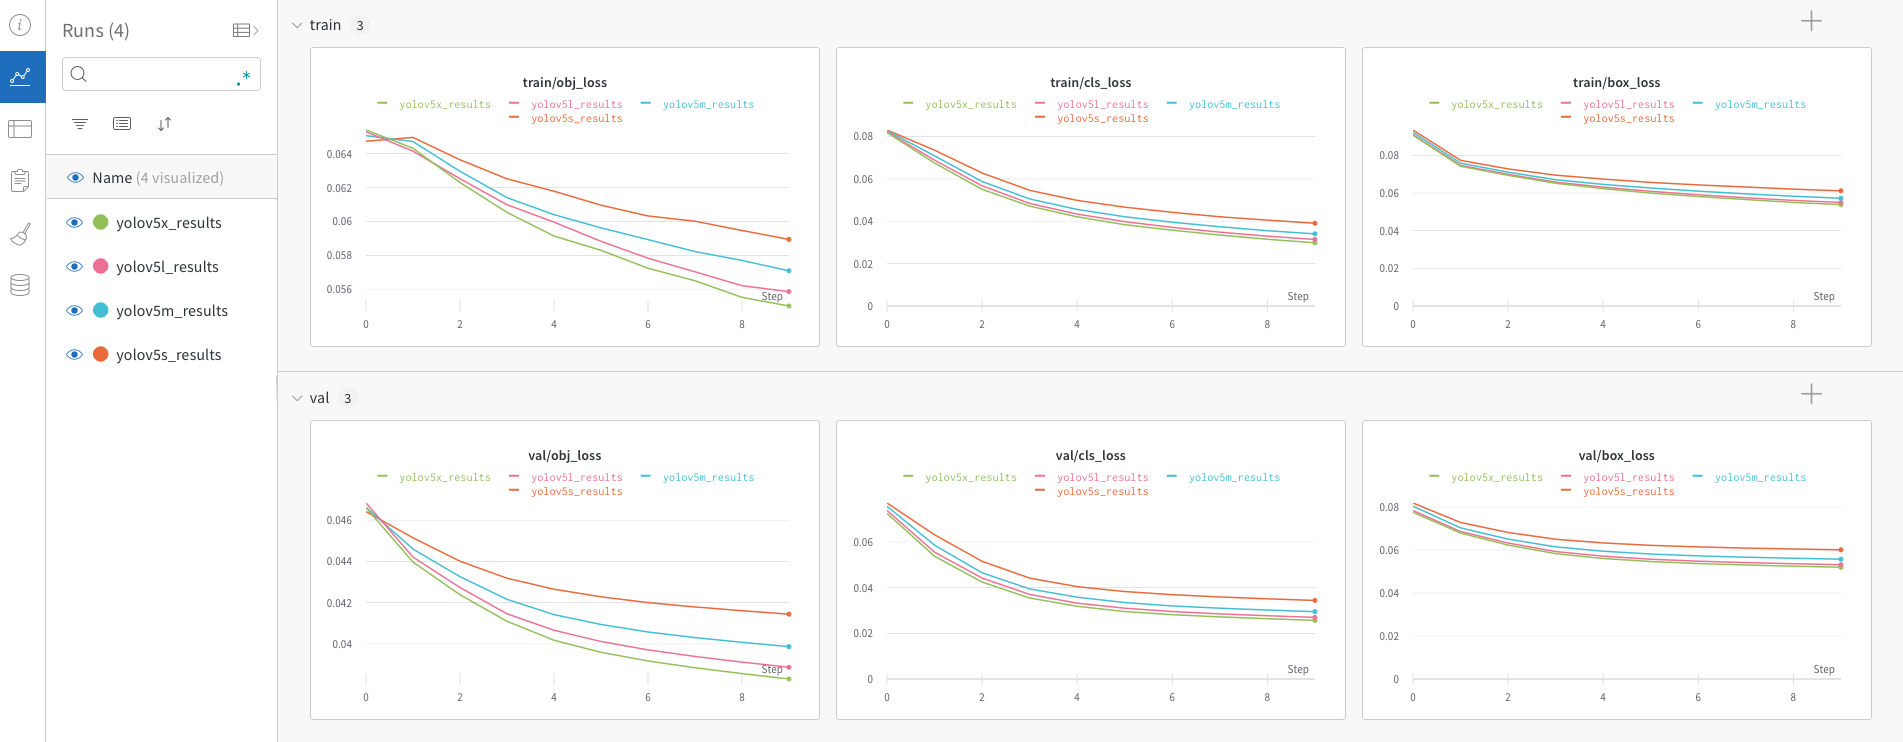

**Precision & Recall:**
- Precision: measures how accurate are the predictions. It is the percentage of your correct predictions.
- Recall: measures how good it finds all the positives.

**mAP (mean Average Precision):** compares the ground-truth bounding box to the detected box and returns a score. The higher the score, the more accurate the model is in its detections.
- mAP@ 0.5：when IoU is set to 0.5, the AP of all pictures of each category is calculated, and then all categories are averaged : mAP.
- mAP@ 0.5:0.95：represents the average mAP at different IoU thresholds (from 0.5 to 0.95 in steps of 0.05).

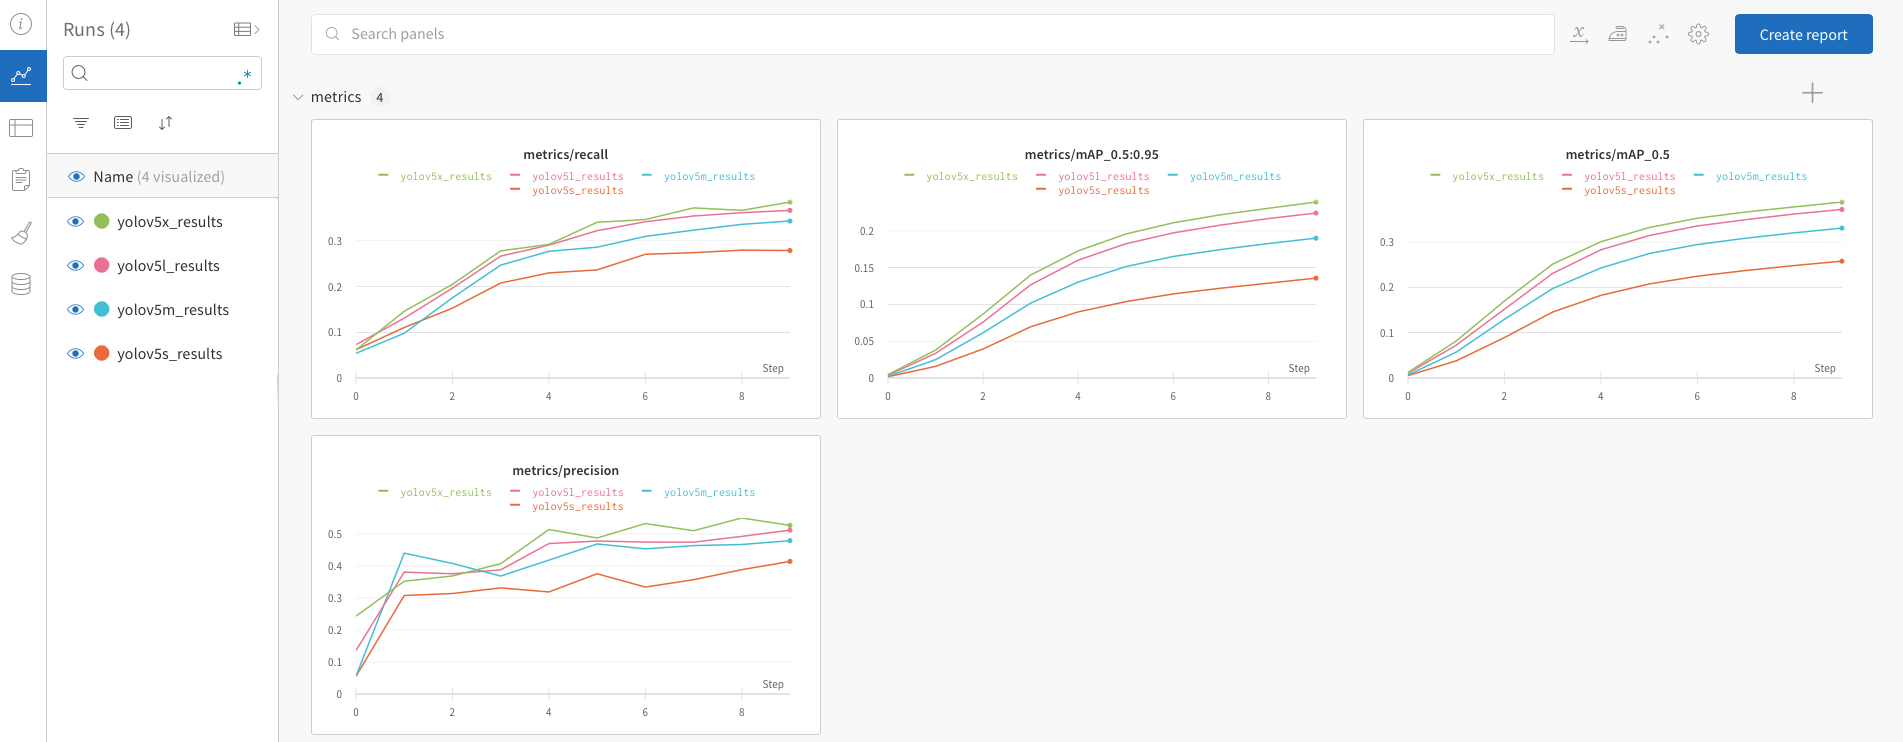

You can compare your trainings by creating an "Parallel coordinates" graph on Weights & Biases. You will be able to evaluate the performance of your trainings.

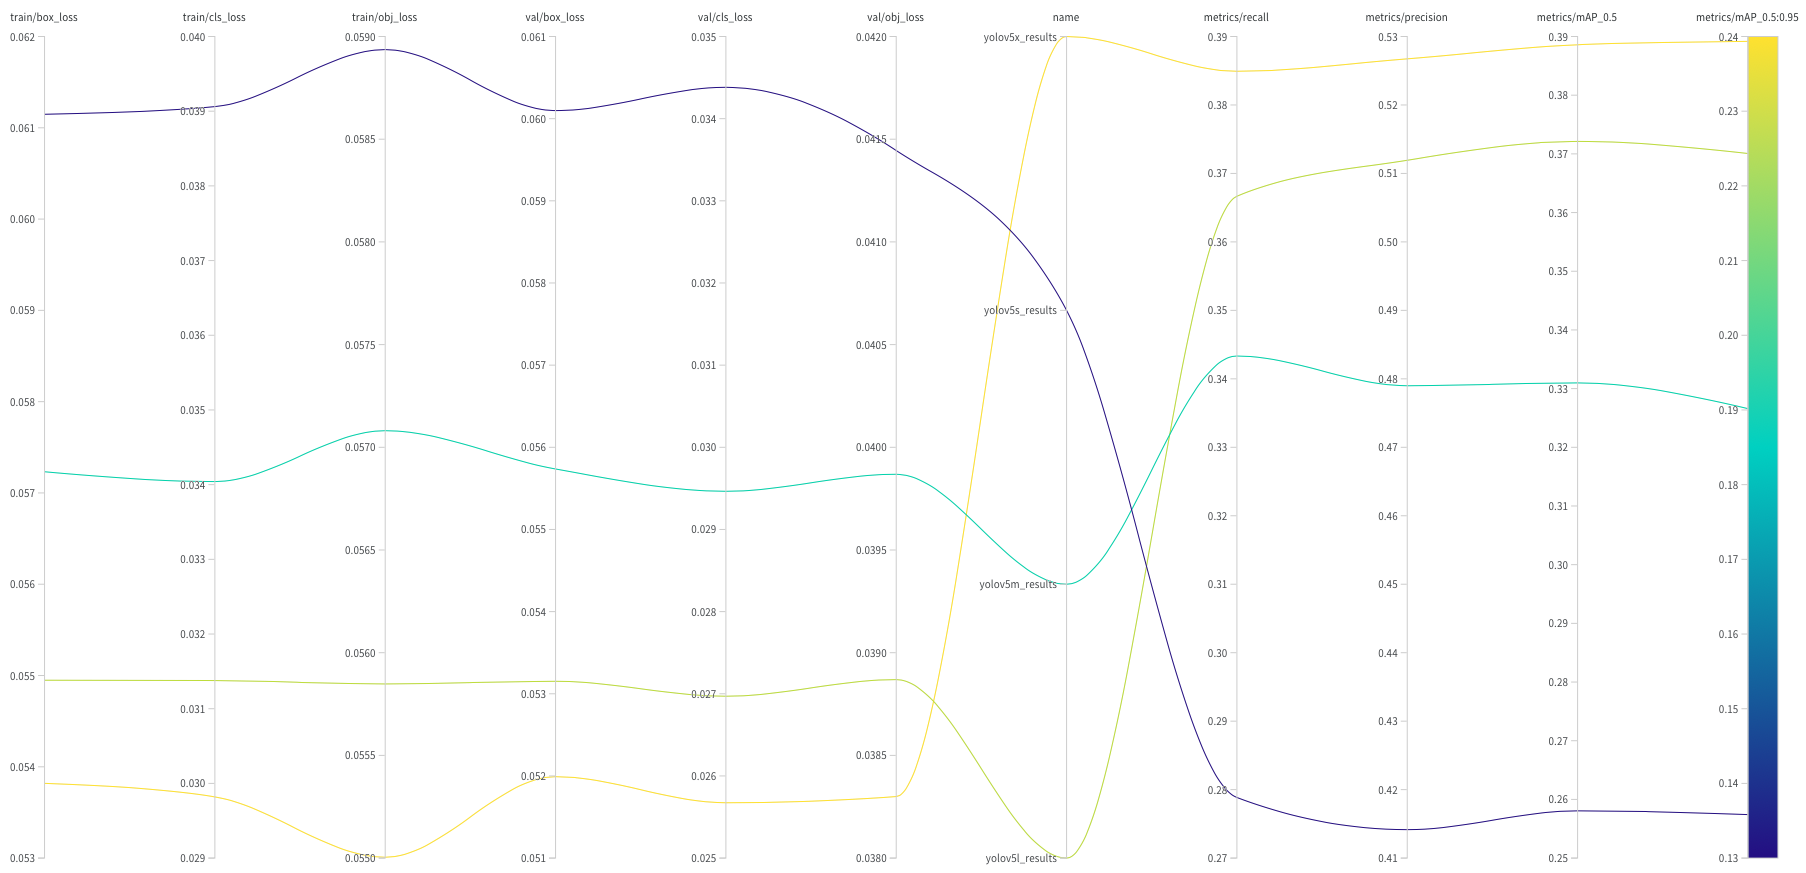

Here we see that the best model seems to be the YOLOv5x for 10 epochs.

You can also see some images from the training:

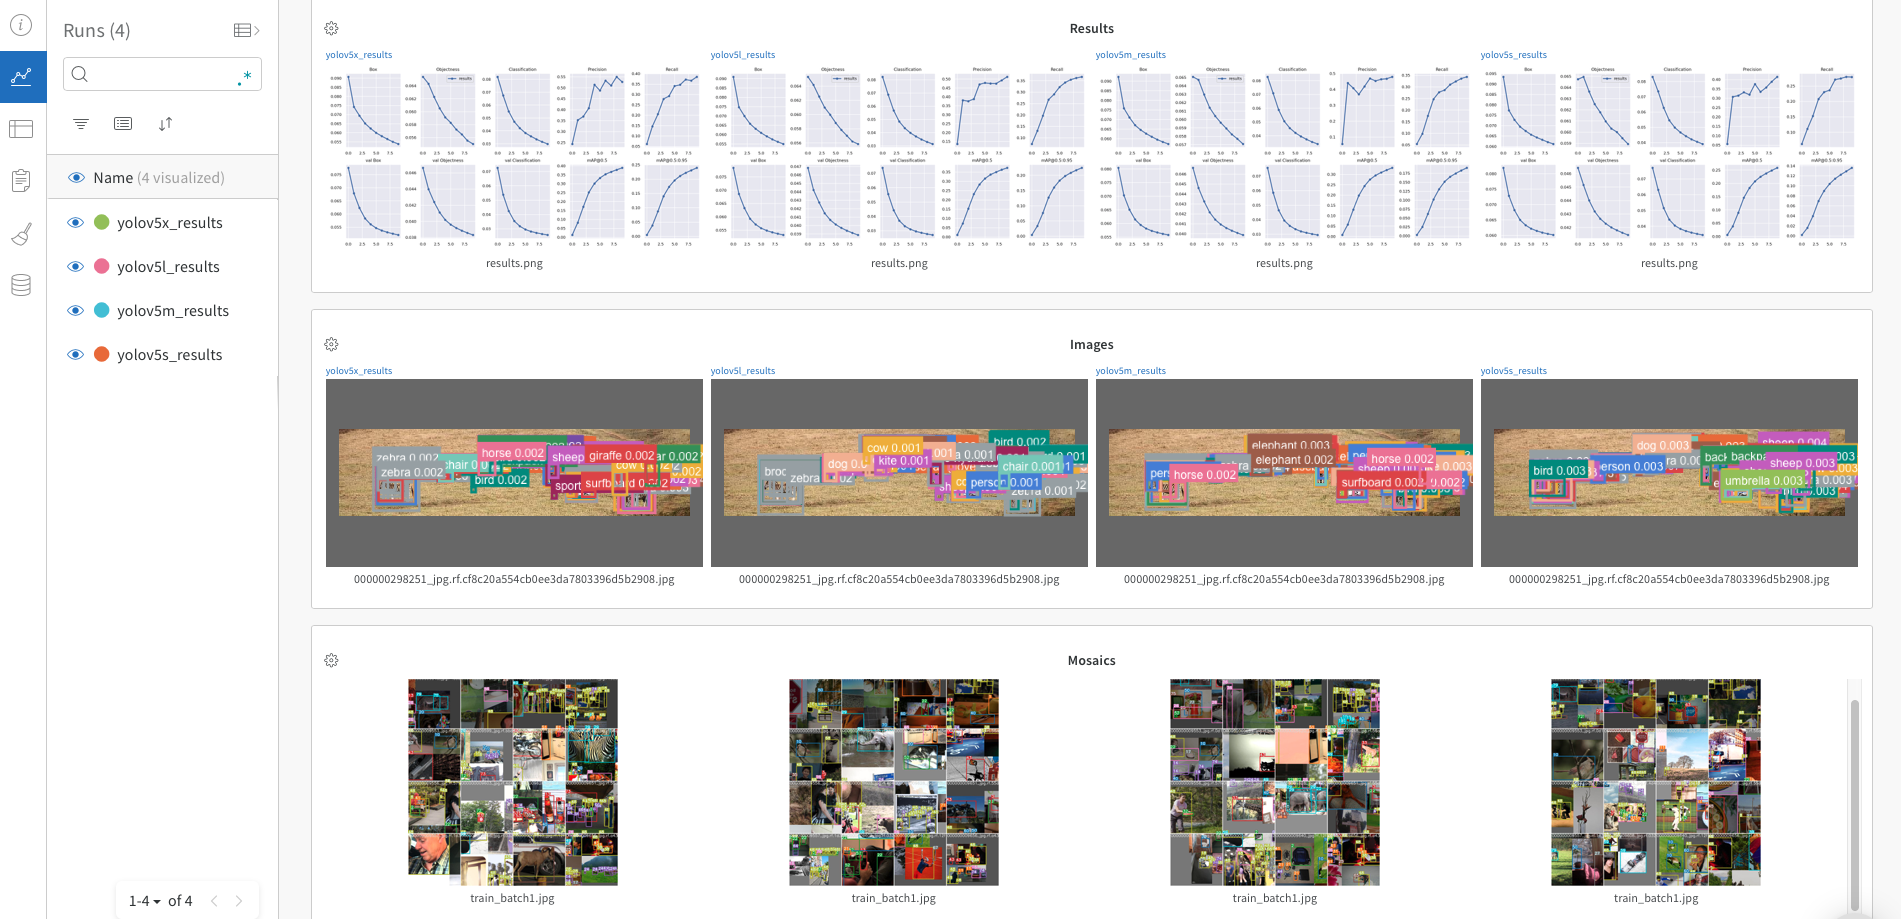

### Use of computing ressources

Weights and Biases allows you to study how models actually use their computational resources. You can therefore see in a simple way how your computational resources are used.

Overview:

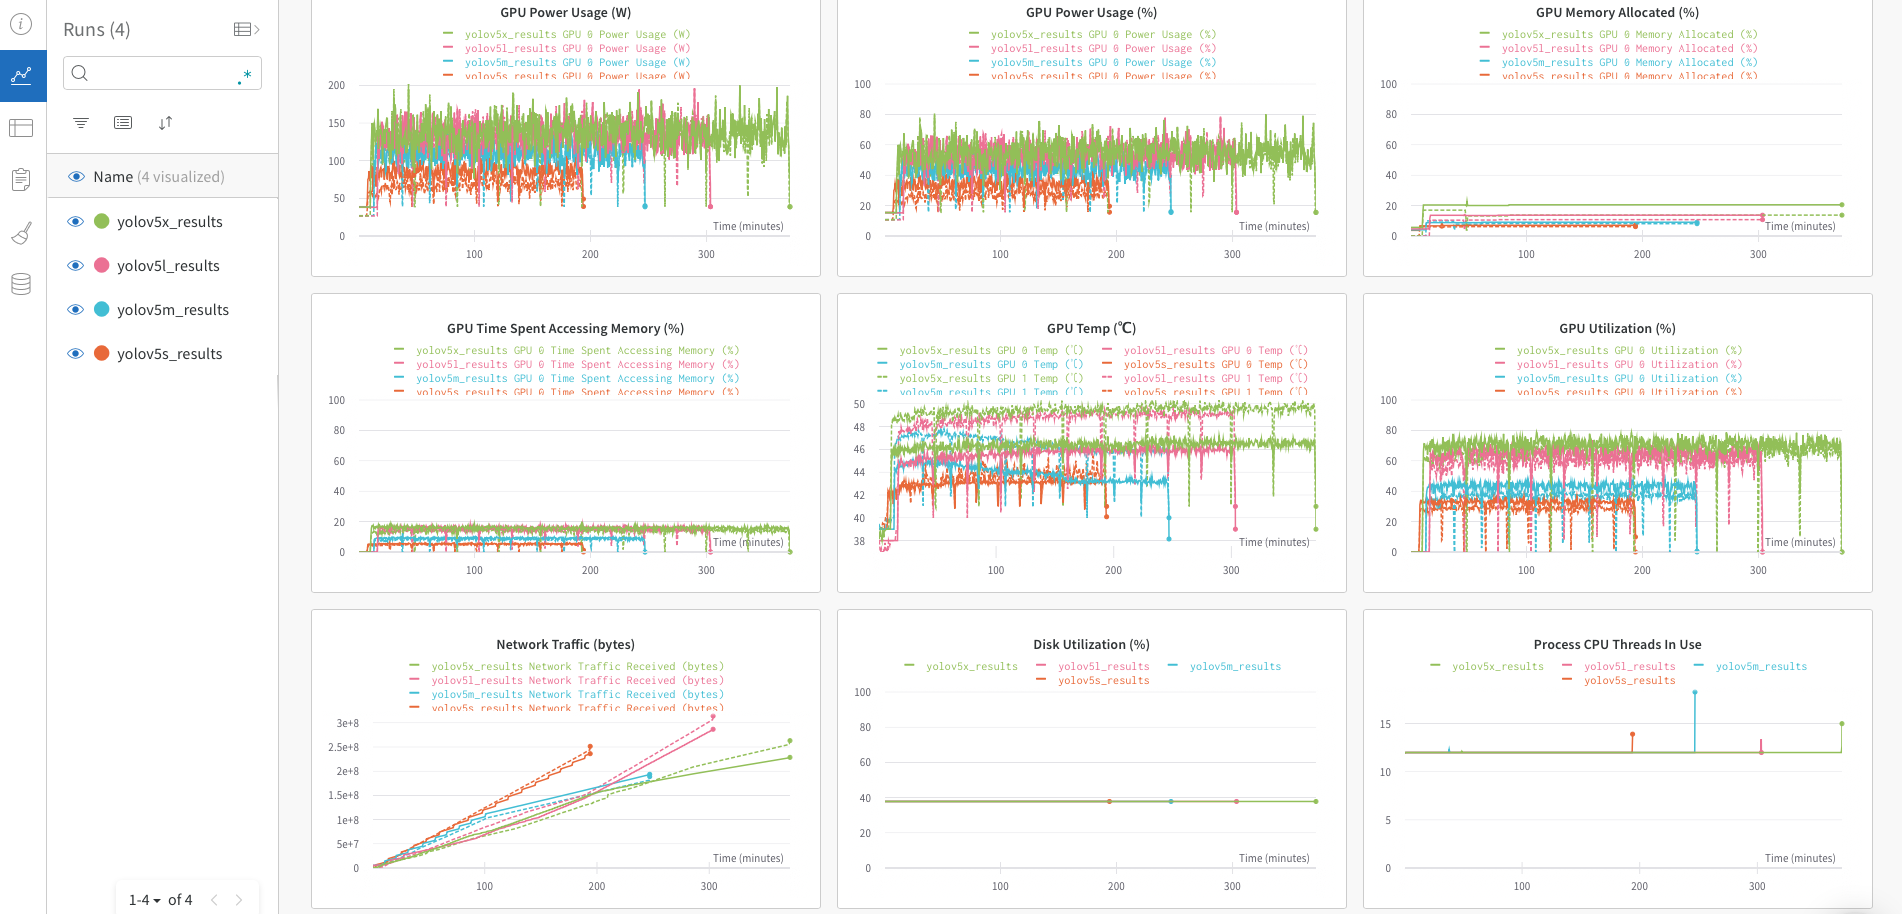